In [1]:
from sklearn.metrics import ndcg_score, average_precision_score
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def baseline_ranker(q, x):
    '''where q is a query and x is a df with "bow" bag of words col set as cocatenation of title/snippet/doc'''
    x = x.copy()
    us = x[(x['for_query']==q) & (x['country']=='us')]
    ru = x[(x['for_query']==q) & (x['country']=='ru')]
    idx_scores = []
    # print('for query:', q)
    for i,row in us.iterrows():
        toks = ' '.join(row['bow']).split(' ') #(' '.join(row['title_en']) +  ' '.join(row['snippet_en']) + ' '.join(row['doc_en'])).split(' ') 
        tok_bucket = ' '.join(ru['bow']).split(' ') #(' '.join(ru['title_en']) +  ' '.join(ru['snippet_en']) + ' '.join(ru['doc_en'])).split(' ') 
        no_overlap = set(toks) - set(tok_bucket)
        idx_scores.append((row['index'], 'us', row['title_en'][:25],(len(no_overlap) / len(toks)) * 5))

    for i,row in ru.iterrows():
        toks = ' '.join(row['bow']).split(' ') #(' '.join(row['title_en']) +  ' '.join(row['snippet_en']) + ' '.join(row['doc_en'])).split(' ') 
        tok_bucket = ' '.join(us['bow']).split(' ')#(' '.join(us['title_en']) +  ' '.join(us['snippet_en']) + ' '.join(us['doc_en'])).split(' ') 
        no_overlap = set(toks) - set(tok_bucket)
        idx_scores.append((row['index'], 'ru',row['title_en'][:25], (len(no_overlap) / len(toks)) * 5))

    return sorted(idx_scores, key=lambda x: x[3], reverse=True)

In [4]:
# load in annotated df
# ann_df = pd.read_csv('bag_')
ann_df = pd.read_excel('data/bag_of_words_translated.xlsx',sheet_name='full_col_translated')

ann_df = ann_df.dropna(subset=['for_query','title','rank','links','country','discordance'])
ann_df = ann_df.reset_index(drop=True).reset_index()
ann_df['bow'] = ann_df.title_en.astype(str) + ann_df.snippet_en.astype(str)  +ann_df.doc_en.astype(str) 
queries_ann = set(ann_df['for_query'])
ann_df[['index','for_query','for_query_en','title','rank','country','discordance']]

,index,for_query,for_query_en,title,rank,country,discordance
0,0,atomic heart,atomic heart,Atomic Heart – Atomic Heart,1.0,ru,0.0
1,1,atomic heart,atomic heart,Atomic Heart on Steam,2.0,ru,1.0
2,2,atomic heart,atomic heart,Atomic Heart | Эксклюзивно на VK Play,3.0,ru,1.0
3,3,atomic heart,atomic heart,Atomic Heart,4.0,ru,2.0
4,4,atomic heart,atomic heart,Atomic Heart,5.0,ru,2.0
...,...,...,...,...,...,...,...
937,937,яндекс,Yandex,Yandex — новости и информация о компании,15.0,ru,1.0
938,938,яндекс,Yandex,"Яндекс, Москва - Как мы делаем Яндекс / Статьи...",16.0,ru,1.0
939,939,яндекс,Yandex,«Яндекс» представил умную колонку «Станция Миди»,17.0,ru,3.0
940,940,яндекс,Yandex,Купить акции Яндекс (YNDX),18.0,ru,4.0


In [107]:
ann_df.value_counts('country')

country
ru    491
us    451
Name: count, dtype: int64

In [108]:
# load in full dataset
ann_df[['title_en','bow',]]

,title_en,bow
0,Atomic Heart – Atomic Heart,Atomic Heart – Atomic Heartnan#VALUE!
1,Atomic Heart on Steam,Atomic Heart on SteamnanWelcome to Steam\t\t\t...
2,Atomic Heart | Exclusively on VK Play,Atomic Heart | Exclusively on VK PlaynanAtomic...
3,Atomic Heart,Atomic HeartnanWikipedia the free encyclopedia...
4,Atomic Heart,Atomic HeartAtomic Heart (from English - “Atom...
...,...,...
937,Yandex - news and information about the company,Yandex - news and information about the compan...
938,"Yandex, Moscow - How do we do Yandex / Article...","Yandex, Moscow - How do we do Yandex / Article..."
939,"Yandex introduced the smart column ""MIDI station""","Yandex introduced the smart column ""MIDI stati..."
940,Buy Yandex Promotions (Yndx),"Buy Yandex Promotions (Yndx)At 10.11.2023, the..."


In [109]:
full_idx_scores = []
for q in queries_ann:
    full_idx_scores += baseline_ranker(q,ann_df)

In [110]:
discdf = pd.DataFrame().from_records(full_idx_scores, columns=['index','country','bow','discordance'])

In [112]:
print(ann_df.loc[23,'discordance'])

1.0


In [5]:
base_rec = []
stat_rec = []
for q in list(queries_ann):
    # baseline DOES NOT ACTUALLY USE DISC SCORES FROM ANN DF
    baseline = baseline_ranker(q, ann_df)
    # print(baseline)

    truth = ann_df[ann_df['for_query']==q]['discordance'].sort_values(ascending=False).to_numpy() # when 3 or above
    query_en = ann_df[ann_df['for_query']==q]['for_query_en'].iloc[0]
    mp = average_precision_score([1 if t > 2 else 0 for t in truth ], [1 if b[3] > 2 else 0 for b in baseline ])
    

    baseline.sort(key=lambda x:x[-1])
    # print(baseline)
    #  baseline_scores = -np.sort(-baseline_scores)

    baseline_scores = np.array([ann_df.loc[b[0],'discordance'] for b in baseline]) #* 5.0
    # print(baseline_scores.shape, len(truth))
    # print(baseline_scores)
    # print(truth)
    ng = ndcg_score(truth[:,None].T, baseline_scores[:,None].T ,k=10)
    # print(ng)
    base_rec.append([q, 'map',mp, query_en])
    base_rec.append([q, 'ndcg',ng, query_en])


    stat_rec.append([q,query_en,stats.ks_2samp(truth, [b[3] for b in baseline])[1]])
statdf=  pd.DataFrame().from_records(stat_rec, columns=['query','query_en','value'])
basedf = pd.DataFrame().from_records(base_rec, columns=['query','score','value','query_en'])

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-pa

In [6]:
basedf.to_csv('baseline_evaluation_results.csv',index=False)

In [7]:
statdf.to_csv('baseline_stat_results.csv',index=False)

/var/folders/yn/vsg2jym17n53j3rtc1ncvd7r0000gn/T/ipykernel_49016/3583225766.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')
/var/folders/yn/vsg2jym17n53j3rtc1ncvd7r0000gn/T/ipykernel_49016/3583225766.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')


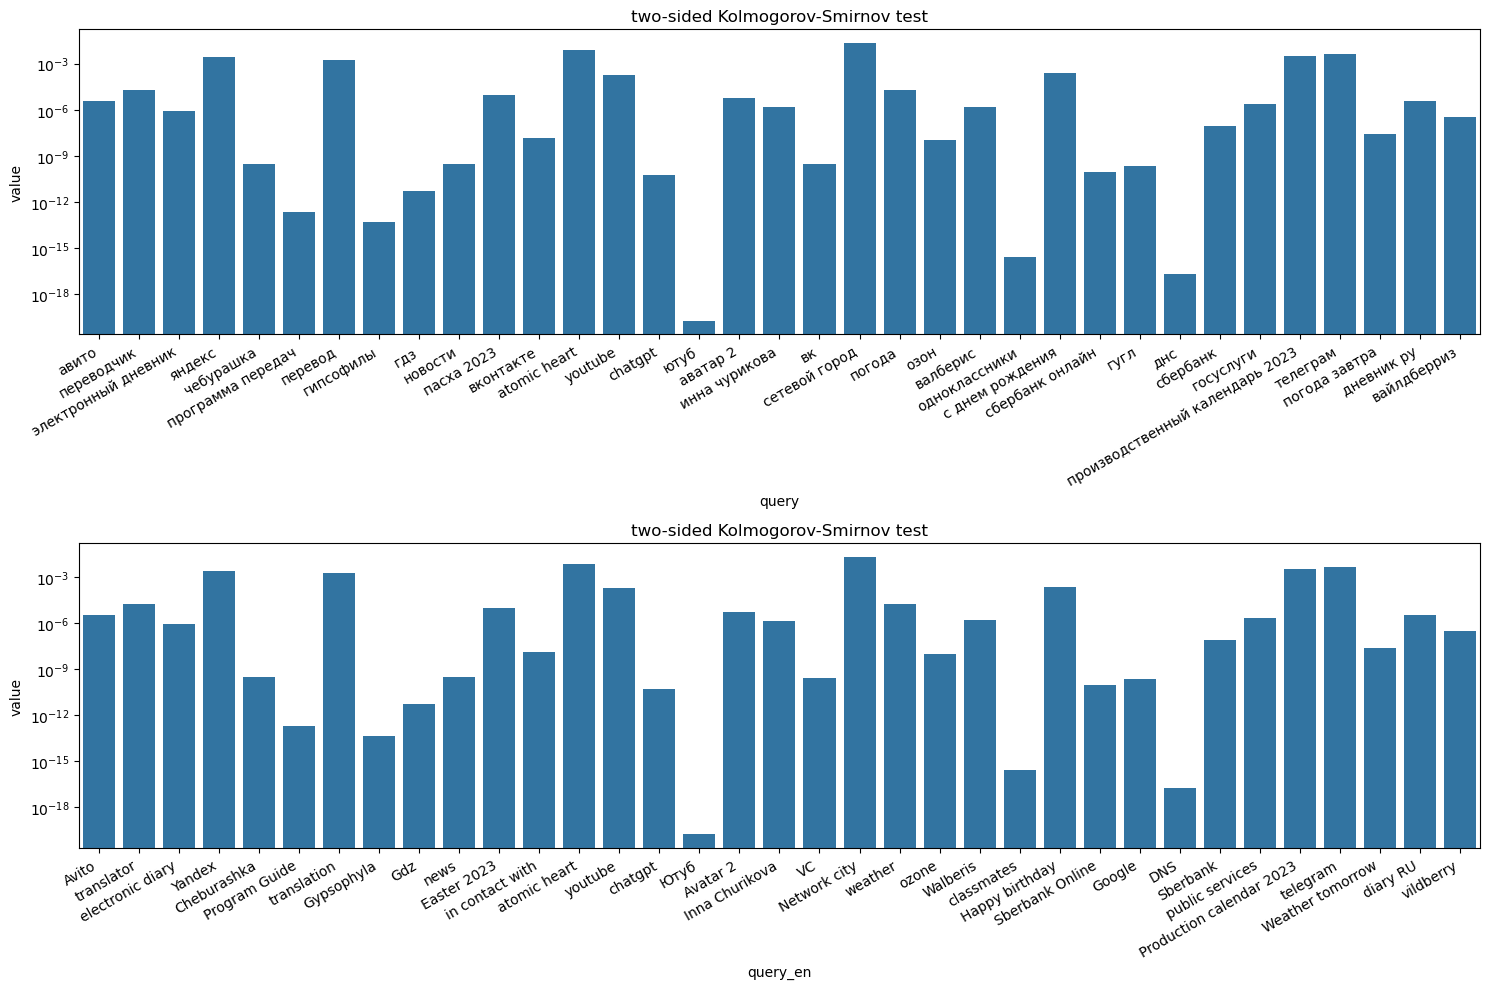

In [134]:
plt.figure(figsize=(15,10))
plt.subplot(211)
chart = sns.barplot(statdf, x='query',y='value')
chart.set(title='two-sided Kolmogorov-Smirnov test',yscale='log')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.subplot(212)
chart = sns.barplot(statdf, x='query_en',y='value')
chart.set(title='two-sided Kolmogorov-Smirnov test',yscale='log')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.tight_layout()
plt.savefig('figures/ks_test.png')


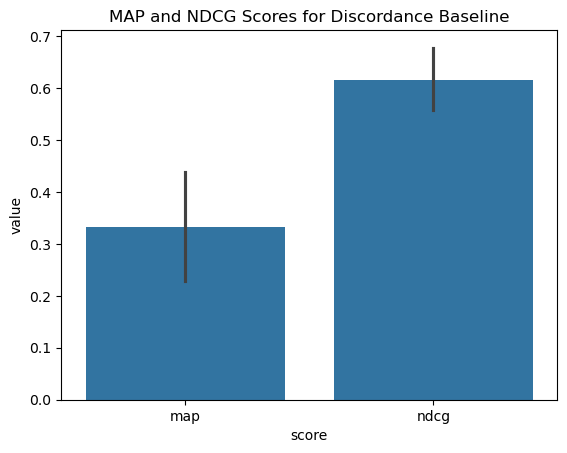

In [135]:
sns.barplot(basedf, x='score',y='value').set(title='MAP and NDCG Scores for Discordance Baseline')
plt.savefig('figures/coarse_map_ndcg_scores.png')

/var/folders/yn/vsg2jym17n53j3rtc1ncvd7r0000gn/T/ipykernel_49016/228246495.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')


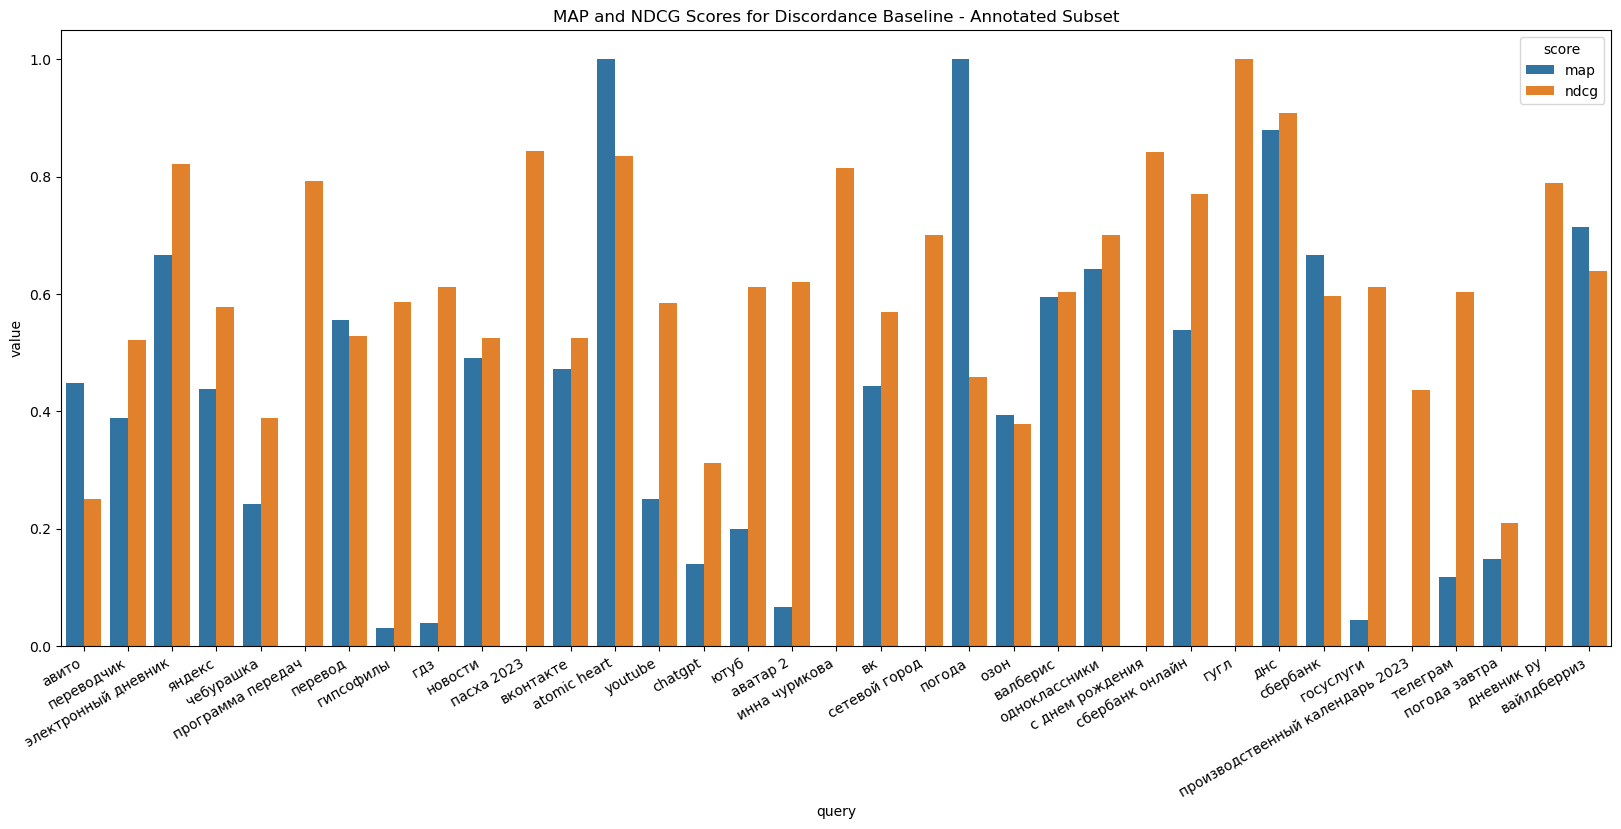

In [136]:
plt.figure(figsize=(20,8))
chart = sns.barplot(basedf, x='query',hue='score', y='value')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')
chart.set(title='MAP and NDCG Scores for Discordance Baseline - Annotated Subset',)
plt.savefig('figures/fine_map_ndcg.png')

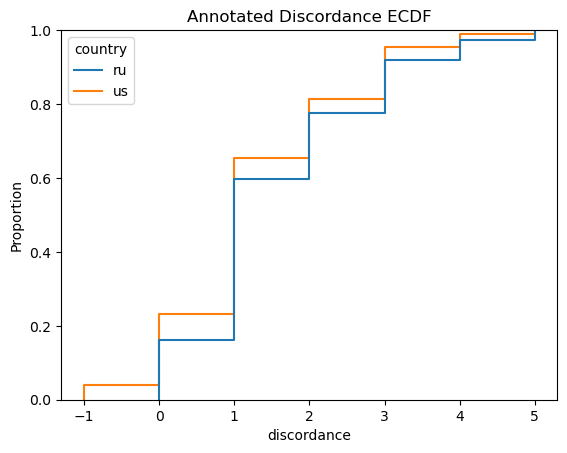

In [142]:
sns.ecdfplot(ann_df, x='discordance',hue='country').set(title='Annotated Discordance ECDF')
plt.savefig('figures/discordance_ecfd.png')

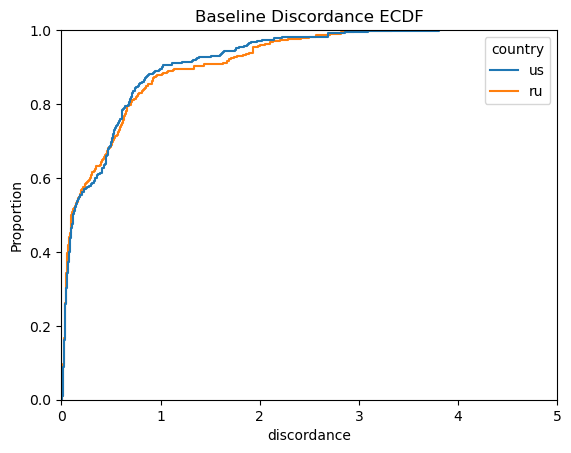

In [141]:
sns.ecdfplot(discdf, x='discordance',hue='country').set(title='Baseline Discordance ECDF', xlim=(0,5))
plt.savefig('figures/baseline_discordance_ecfd.png')